In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [118]:
from PIL import Image
from numpy import *
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

## Sample Code for 2 x 2 pixels image edge detection

In [119]:
img = Image.open('2x2.png')
  
# summarize some details about the image
print(img.format)
print(img.size)
print(img.mode)

PNG
(2, 2)
RGBA


In [120]:
image = asarray(img)
  
# <class 'numpy.ndarray'>
print(type(image))
  
#  shape
print(image.shape)

<class 'numpy.ndarray'>
(2, 2, 4)


In [121]:
print(image)

[[[255 255 255   0]
  [255 255 255   0]]

 [[255 255 255   0]
  [255 255 255   0]]]


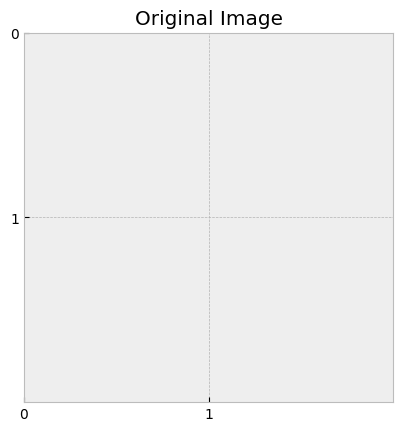

In [122]:
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [123]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)
print("\n\n\n",image_norm_v)

[[73.61215932 73.61215932 73.61215932  0.        ]
 [73.61215932 73.61215932 73.61215932  0.        ]
 [73.61215932 73.61215932 73.61215932  0.        ]
 [73.61215932 73.61215932 73.61215932  0.        ]]



 [[73.61215932 73.61215932]
 [73.61215932 73.61215932]
 [73.61215932 73.61215932]
 [73.61215932 73.61215932]
 [73.61215932 73.61215932]
 [73.61215932 73.61215932]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [124]:
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)
#print(image_norm_h)


image_norm_h = image_norm_h.flatten()

norm = np.linalg.norm(image_norm_h)
image_norm_h = image_norm_h/norm


print(image_norm_h)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)
#print(image_norm_v)

image_norm_v = image_norm_v.flatten()


norm = np.linalg.norm(image_norm_v)
image_norm_v = image_norm_v/norm


print("\n\n\n",image_norm_v)

[0.28867513 0.28867513 0.28867513 0.         0.28867513 0.28867513
 0.28867513 0.         0.28867513 0.28867513 0.28867513 0.
 0.28867513 0.28867513 0.28867513 0.        ]



 [0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513 0.28867513
 0.         0.         0.         0.        ]


In [125]:
# Initialize some global variable for number of qubits
data_qb = 4
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

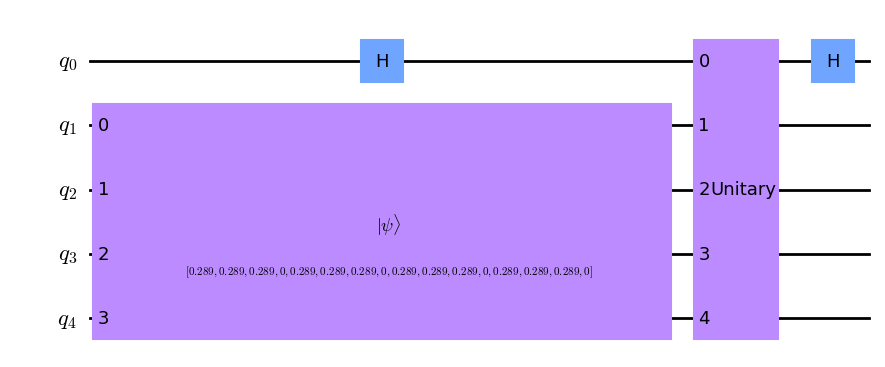

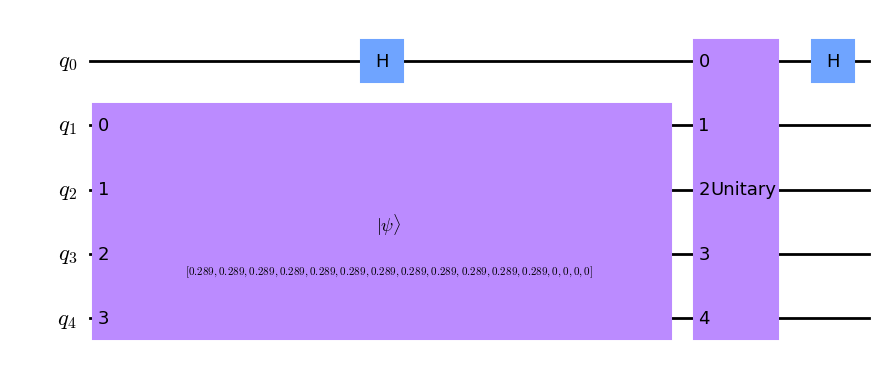

In [126]:
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [127]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

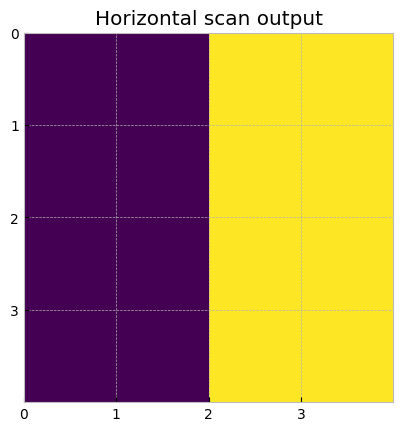

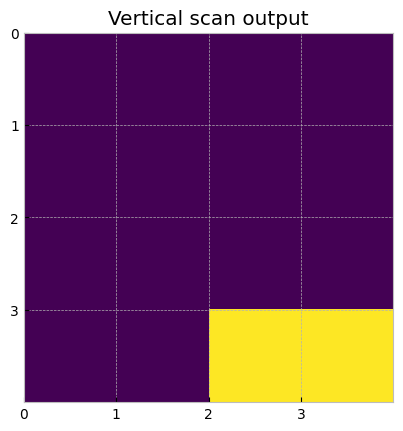

In [128]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(4, 4)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(4, 4).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

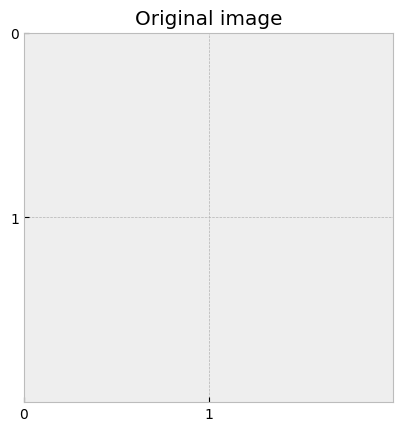

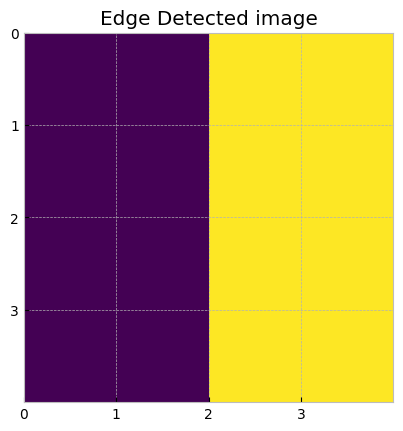

In [129]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

In [130]:
from qiskit import IBMQ

# Load the IBMQ account
IBMQ.load_account()

# Get the provider and backend
provider = IBMQ.get_provider(hub='ibm-q', group='open')
backend = provider.get_backend('ibmq_santiago')

ibmqfactory.load_account:WARNING:2021-10-19 14:40:05,651: Credentials are already in use. The existing account in the session will be replaced.


ValueError: zero-size array to reduction operation minimum which has no identity

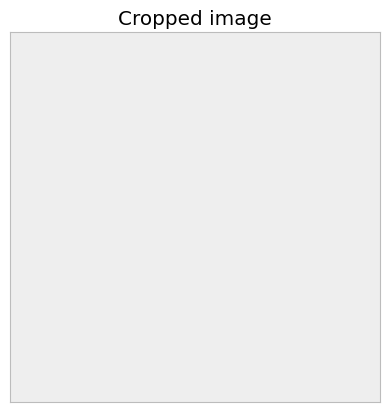

In [131]:
# Create a 2x2 image to be run on the hardware
# The pixels in `image_small` correspond to the pixels at
# (6, 2), (6, 3), (7, 2), (7, 3) respectively
image_small = image[6:8, 2:4]

# Plotting the image_small using matplotlib
plot_image(image_small, 'Cropped image')

In [132]:
# Initialize the number of qubits
data_qb = 2
anc_qb = 1
total_qb = data_qb + anc_qb

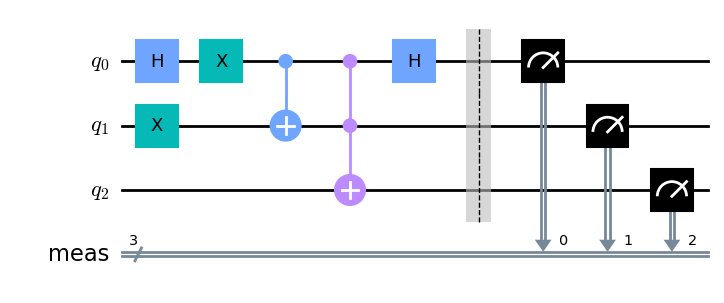

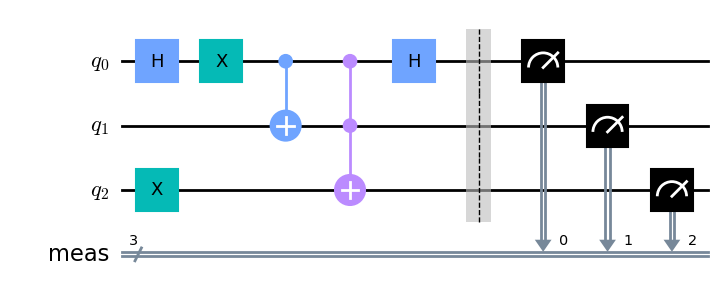

In [133]:
# Create the circuit for horizontal scan
qc_small_h = QuantumCircuit(total_qb)
qc_small_h.x(1)
qc_small_h.h(0)

# Decrement gate - START
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# Decrement gate - END

qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

# Create the circuit for vertical scan
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)

# Decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# Decrement gate - END

qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# Combine both circuits into a single list
circ_list = [qc_small_h, qc_small_v]

In [134]:
# Transpile the circuits for optimized execution on the backend
qc_small_h_t = transpile(qc_small_h, backend=backend, optimization_level=3)
qc_small_v_t = transpile(qc_small_v, backend=backend, optimization_level=3)

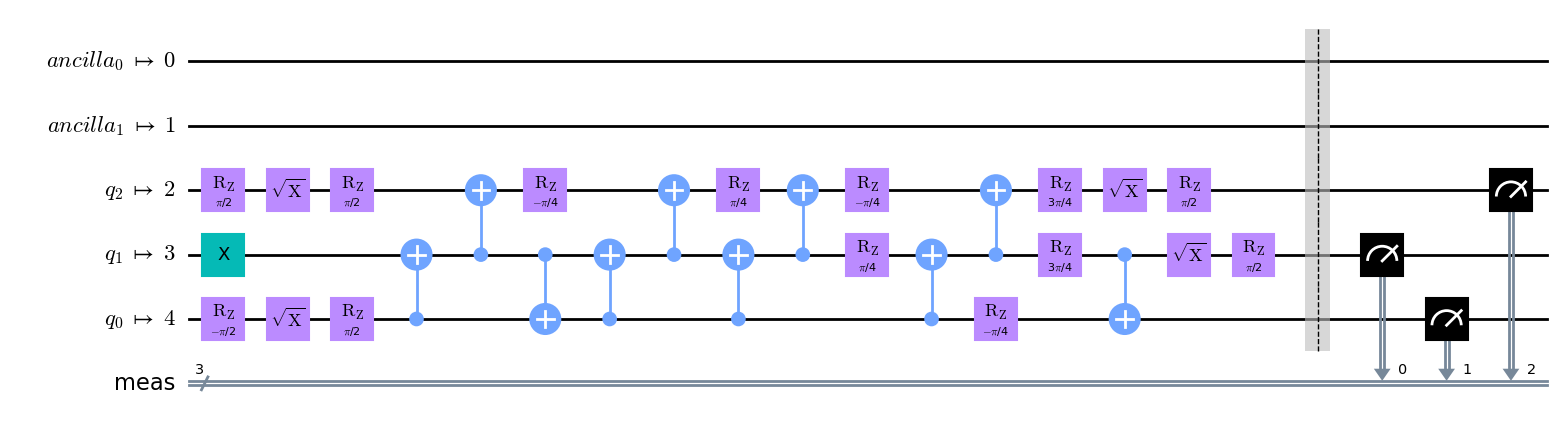

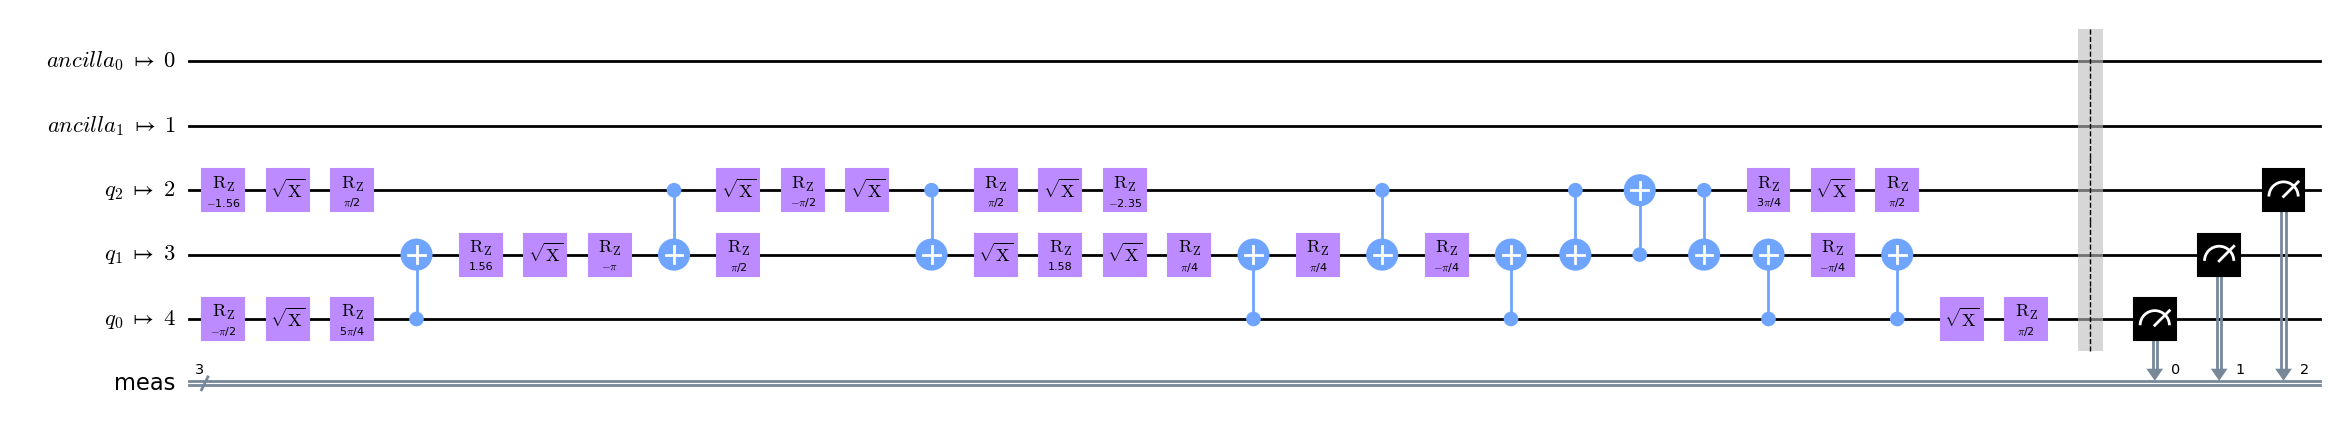

In [135]:
# Combining both circuits into a list
circ_list_t = [qc_small_h_t, qc_small_v_t]

# Drawing the transpiled circuit
display(circ_list_t[0].draw('mpl', fold=-1))
display(circ_list_t[1].draw('mpl', fold=-1))

In [136]:
from qiskit.tools.monitor import job_monitor

# Executing the circuits on the backend
job = execute(circ_list_t, backend=backend, shots=8192)
job_monitor(job)

Job Status: job has successfully run


Counts for Horizontal scan:


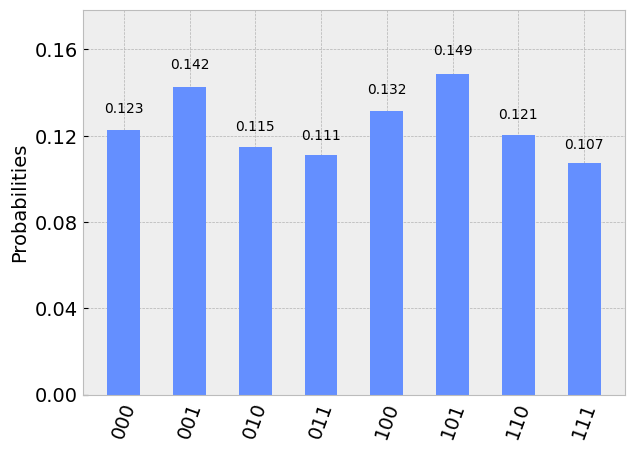



Counts for Vertical scan:


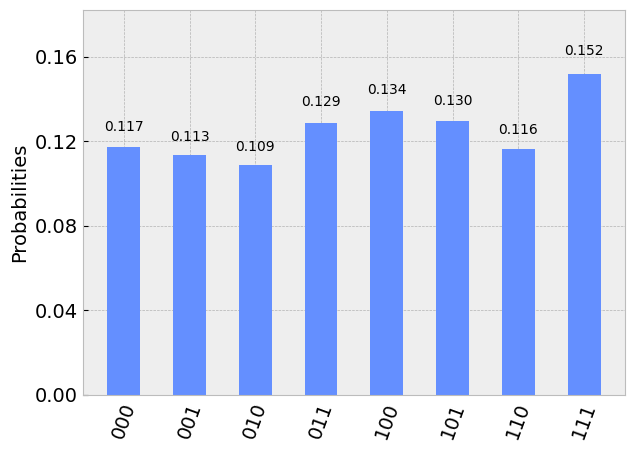

In [137]:
from qiskit.visualization import plot_histogram

# Getting the resultant probability distribution after measurement
result = job.result()
counts_h = result.get_counts(qc_small_h)
counts_v = result.get_counts(qc_small_v)

print('Counts for Horizontal scan:')
display(plot_histogram(counts_h))

print('\n\nCounts for Vertical scan:')
display(plot_histogram(counts_v))

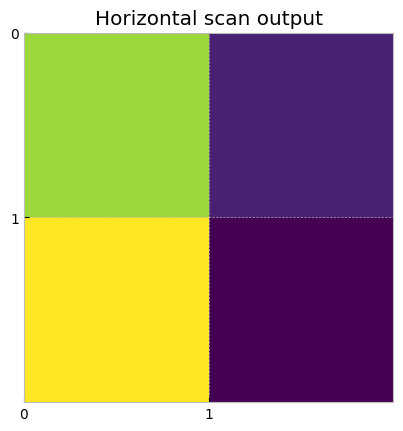

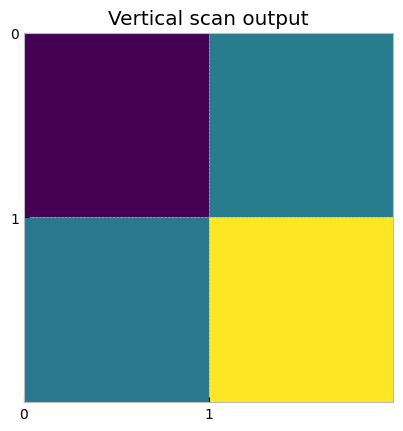

In [138]:
# Extracting counts for odd-numbered states
edge_scan_small_h = np.array([counts_h[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2, 2)
edge_scan_small_v = np.array([counts_v[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2, 2).T

plot_image(edge_scan_small_h, 'Horizontal scan output')
plot_image(edge_scan_small_v, 'Vertical scan output')

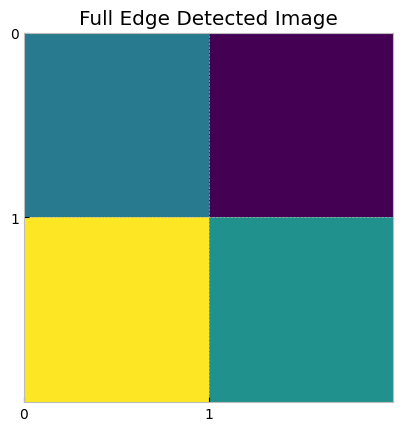

In [139]:
edge_detected_image_small = edge_scan_small_h + edge_scan_small_v

# Plotting the original and edge-detected images
plot_image(edge_detected_image_small, 'Full Edge Detected Image')

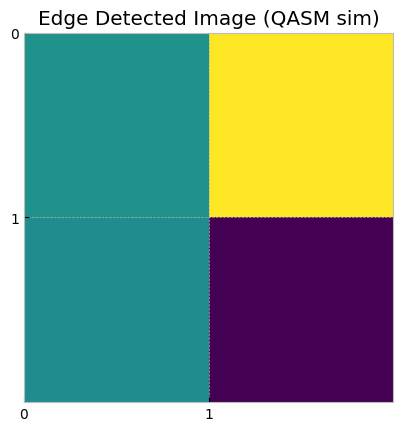

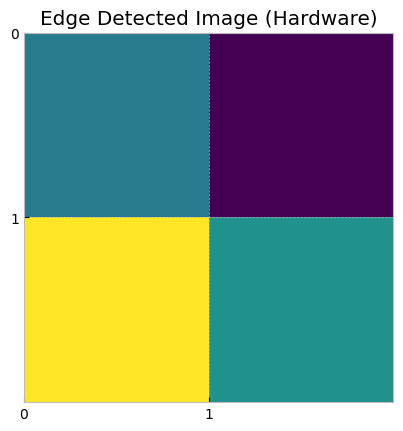

ValueError: zero-size array to reduction operation minimum which has no identity

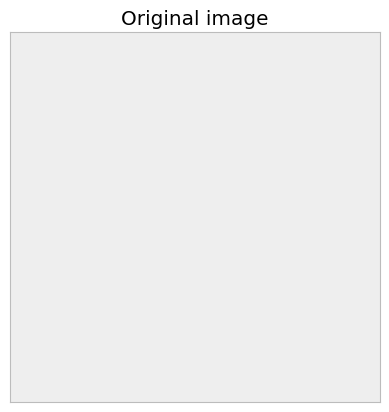

In [140]:
# Initialise the qasm_simulator from the Aer package
sim = Aer.get_backend('qasm_simulator')
res = sim.run(circ_list_t, shots=8192).result()
sim_counts_h = res.get_counts(qc_small_h)
sim_counts_v = res.get_counts(qc_small_v)

# Get the measurement counts from the result
sim_keys_h = sim_counts_h.keys()
sim_keys_v = sim_counts_v.keys()

# Filter and extract the counts for odd-numbered states
# and make the full edge-detected image by adding horizontal and vertical scans
edge_scan_sim_h = np.array([sim_counts_h[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_h else 0 for i in range(2**data_qb)]).reshape(2, 2)
edge_scan_sim_v = np.array([sim_counts_v[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_v else 0 for i in range(2**data_qb)]).reshape(2, 2).T
edge_detected_sim_small = edge_scan_sim_h + edge_scan_sim_v

# Plot all the simulator-run, hardware-run, and original images
plot_image(edge_detected_sim_small, 'Edge Detected Image (QASM sim)')
plot_image(edge_detected_image_small, 'Edge Detected Image (Hardware)')
plot_image(image_small, 'Original image')